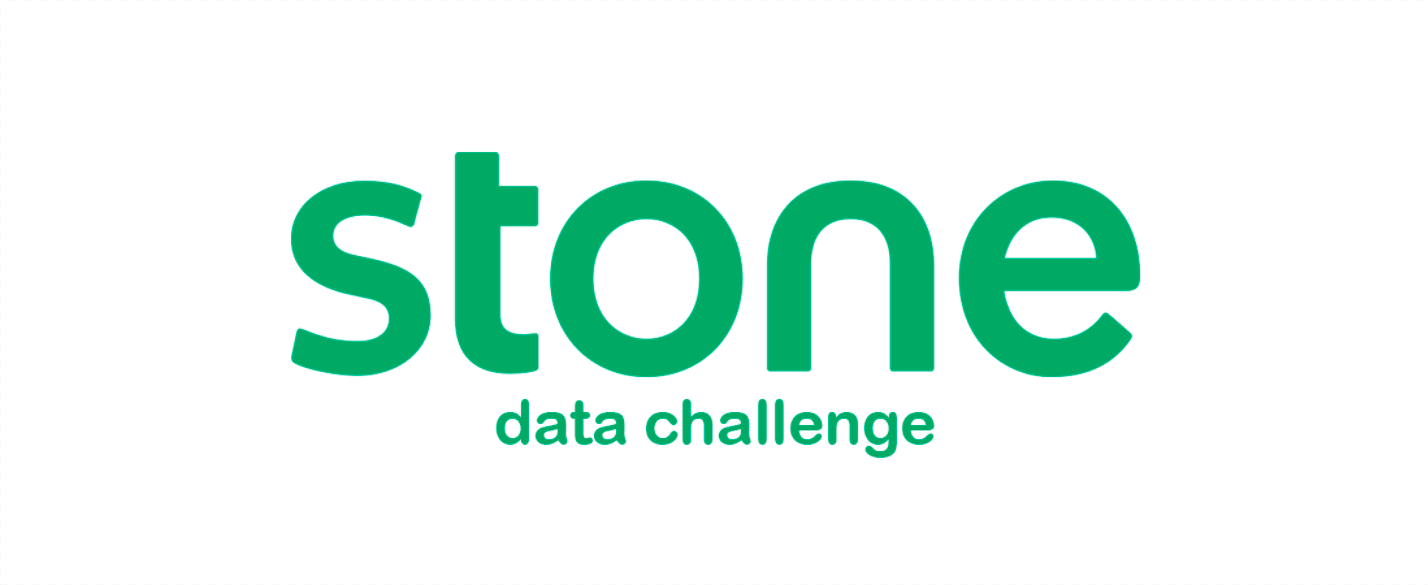

#### **Objetivo do Modelo**:
* Para cada um dos mais de 200 mil clientes, estimar o TPV mensal de Agosto à Dezembro de 2020. A métrica a ser utilizada na avaliação é o erro absoluto relativo. 


#### **Metodologia**:
* **Preparação dos Dados**:
    * Parsing e decomposição das datas
    * Feature Engineering (label encoding, agrupamento, redução de categorias e muitos outros - mais detalhes no script `preprocessing.py`)
    * Imputação de valores utilizando FFill.
    * Padronização da variável Estado
    * Criação de Lags e Diffs do TPV-Mensal


* **Baseline**
    * Média dos últimos meses (com vazamento de dados)
    * Média dos últimos meses (sem vazamento de dados)
    * TPV do último mes (só se aplica para validação)
    
    
* **Definição do Modelo**
    * Devido ao alto número de features categóricas e categorias, decidi por modelos ensemble.
    * Foram treinados modelos em 3 algoritmos diferentes - RandomForest, CatBoost e LightGBM
        * RandomForest foi escolhido por ser um bom baseline com hiperparâmetros padrão.
        * Além da ótima perfomance padrão, o CatBoost foi escolhido por funcionar muito bem com dados categóricos.
        * LightGBM lida muito bem com categóricos label encoded e permite maior controle dos hiperparâmetros, permitindo alcançar métricas melhores.
    * RandomForest foi descartado por não ser eficiente com esse volume de dados.
    
* **Hiperparametrização**:
    * Utilizei o Optuna (integrado ao LightGBM e API padrão) para realizar a hiperparametrização.


* **Modelo Final**
    * CatBOOST.


* **Métricas de Avaliação**
    * MAE - Mean Absolute Error. Se aproxima muito da métrica utilizada no desafio.
    * Idealmente, eu acredito que para esse problema o uso do RMLSE poderia ser interessante também (considerando o range que o TPV-Value pode alcançar)


* **Validação**
    * O dataset foi separado em set de treino e teste de forma aleatória.
    * Os modelos foram treinados no set de treino**, utilizando validação sliding window entre os meses de Março e Julho.
        * **A única exceção foi o RandomForest, devido à ineficiência nesse volume de dados.
    * Em seguida, os modelos foram aplicados no set de teste para verificar a capacidade de generalização.
    
* **Dataset Resultante**:
    * `previsoes_ago_dez.csv`
    

**OBS.:** O LightGBM não oferece suporte para suprimir alguns warnings e como estou utilizando um loop para realizar o sliding window, as células que treinam o modelo acabam tendo um output bem poluído.

### Iniando o Notebook

In [1]:
# Import libs

# Wrangling e Analysis
import pandas as pd
import numpy as np

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestRegressor
import catboost as cb
import optuna
import optuna.integration.lightgbm as lgb

# Metrics
from sklearn.metrics import mean_absolute_error

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Import nos datasets
df = pd.read_csv('data/df_modelo.csv', parse_dates = ['mes_referencia'])
df.drop("Unnamed: 0", axis = 1, inplace = True)

In [3]:
df = df.sort_values(['mes_referencia', 'id'])
df

,id,mes_referencia,TPV_mensal,Mês,Trimestre,Ano,tpv_ultimo_mes,diff_ultimo_mes,tpv_ultimo-1_mes,diff_ultimo-1_mes,...,is_missing_sub_segmento,persona,porte,tipo_documento,Estado,is_missing_Estado,tem_duplicados,StoneCreatedDate,diff_FirstTransaction_Created,Região
466,29,2017-07-31,"52,103.00",7,3,2017,nan,nan,nan,nan,...,0,11,6,2,6,0,1,36,0.82,0
503,30,2017-07-31,"2,549.80",7,3,2017,nan,nan,nan,nan,...,0,8,3,2,10,0,1,37,2.18,4
1366,86,2017-07-31,"10,010.96",7,3,2017,nan,nan,nan,nan,...,0,11,5,2,19,0,0,64,1.26,4
1934,126,2017-07-31,"9,935.00",7,3,2017,nan,nan,nan,nan,...,0,6,4,2,26,0,1,35,2.20,4
2277,150,2017-07-31,"9,453.05",7,3,2017,nan,nan,nan,nan,...,0,7,3,2,10,0,1,9,2.60,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066739,206326,2020-07-31,"10,984.30",7,3,2020,570.00,-405.00,570.00,-405.00,...,0,7,4,1,26,0,0,87,1.26,4
3066746,206327,2020-07-31,"50,545.80",7,3,2020,"49,672.30","31,805.90","49,672.30","31,805.90",...,0,7,4,2,16,0,0,95,0.39,2
3066759,206328,2020-07-31,"4,680.00",7,3,2020,"3,810.00",-90.00,"3,810.00",-90.00,...,0,2,2,1,19,0,0,89,0.82,4
3066767,206329,2020-07-31,"60,213.99",7,3,2020,"61,699.27","5,998.70","61,699.27","5,998.70",...,0,11,6,2,10,0,0,94,1.68,4


In [4]:
# Separando sets - train e test set
all_ids = np.array(df.id.unique())

np.random.seed(42)
test_ids = np.random.choice(all_ids, size = round(0.15*len(all_ids)))

df_test = df[df.id.isin(test_ids)]
df_train = df[~df.id.isin(test_ids)]

Uma vez separados os sets de treino e de teste e confirmado que está tudo correto, podemos calcular o score baseline. Irei utilizar os últimos meses do dataset (Mar/2020 - Jul/2020) para testar o funcionamento dos modelos. Após a previsão do primeiro mês, o modelo incorporará o mês previsto para prever o próximo (sliding window). 

### Baselines

Irei utilizar 3 baselines para comparar os resultados.

* Erro comparando a venda atual com a venda do último mês.
    * Esse é um score baseline considerado relativamente forte para séries temporais, principalmente quando atribuídas à vendas ou saídas de produto.
* Erro comparando a venda atual com a média das vendas até o mês atual.
    * Definido de acordo com o PDF do case.
* Erro comparando a venda atual com a média das vendas incluindo o mês atual e seguintes, se aplicável.
    * Também definido de acordo com o PDF do case, nesse caso ocorre vazamento de dados o que aumenta o score.

In [27]:
# Definindo Baselines - Venda do Ultimo Mes

mean_error = []

for mes in range(3,8):
    val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]

    val = val.fillna(0)
    pred = val['tpv_ultimo_mes'].values

    error = mean_absolute_error(val['TPV_mensal'].values, pred)
    
    print('Mês %d - Error %.5f' % (mes, error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Mês 3 - Error 7490.14150
Mês 4 - Error 7544.06240
Mês 5 - Error 6555.97363
Mês 6 - Error 5691.07836
Mês 7 - Error 6123.64362
Mean Error = 6680.97990


In [28]:
# Definindo Baselines - #2 Média dos últimos meses (nao conta em frente)
mean_error = []

for mes in range(3,8):     
    val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]
    ids = val['id'].unique()
    
    pred = df_train[(df_train['id'].isin(ids)) & (df_train['mes_referencia'] < np.datetime64(f'2020-0{mes + 1}'))]\
                                                                            .groupby('id')['TPV_mensal']\
                                                                            .mean()

    error = mean_absolute_error(val['TPV_mensal'].values, pred)
    
    print('Mês %d - Error %.5f' % (mes, error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Mês 3 - Error 6942.39260
Mês 4 - Error 9223.32410
Mês 5 - Error 8936.66330
Mês 6 - Error 8427.84512
Mês 7 - Error 9413.33451
Mean Error = 8588.71193


In [29]:
# Definindo Baselines - #3 Média de todos os últimos meses
mean_error = []

for mes in range(3,8):     
    val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]
    ids = val['id'].unique()
    
    pred = df_train[(df_train['id'].isin(ids))].groupby('id')['TPV_mensal'].mean()

    error = mean_absolute_error(val['TPV_mensal'].values, pred)
    
    print('Mês %d - Error %.5f' % (mes, error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Mês 3 - Error 6589.17186
Mês 4 - Error 8705.23750
Mês 5 - Error 8215.67843
Mês 6 - Error 7805.07531
Mês 7 - Error 9413.33451
Mean Error = 8145.69952


Como esperado, os scores entre as baselines:
1. Erro da Venda do Último Mês: **6680.97**
2. Erro da Média de Todos os Meses: **8145.69**
3. Erro da Média dos últimos meses (nao conta em frente): **8588.71**

### RF Default e HiperParametrização do LightGBM e do CatBoost

**Obs.:** Esses não são os melhores hiperparametros possíveis. Talvez seja possível aumentar a precisão mas devido ao tempo para a entrega, reduzi o tempo de busca.

In [8]:
#### Random Forest

# Hiperparametros padrao

mean_error = []

for mes in range(3,8):
    
    # RF foi extremamente ineficiente no set de treino e decidi treina-lo apenas no set de test.
    
    train = df_test[df_test['mes_referencia'] < np.datetime64(f'2020-0{mes}')]
    val = df_test[(df_test['Ano'] == 2020) & (df_test['Mês'] == mes)]
    
    # RF não lida c/ valores NaN por padrão
    
    val = val.fillna(0)
    train = train.fillna(0)
    
    X_train, X_test = train.drop(['TPV_mensal', 'mes_referencia'], axis=1), val.drop(['TPV_mensal', 'mes_referencia'], axis=1)
    y_train, y_test = train['TPV_mensal'].values, val['TPV_mensal'].values

    # Instancia e Fita o Modelo
    
    model = RandomForestRegressor(n_estimators=100, n_jobs=8, random_state=0)
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)

    error = mean_absolute_error(y_test, pred)
    
    print('Mês %d - Error %.5f' % (mes, error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Mês 3 - Error 7697.02995
Mês 4 - Error 8197.78799
Mês 5 - Error 6590.88806
Mês 6 - Error 5634.51405
Mês 7 - Error 5898.83429
Mean Error = 6803.81086


In [22]:
#### LightGBM

# HyperOPT c/ Optuna 

mean_error = []

for mes in range(3,8):
    
    train = df_train[df_train['mes_referencia'] < np.datetime64(f'2020-0{mes}')]
    
    val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]
    
    X_train, X_test = train.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1),
                      val.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
        
    y_train, y_test = train['TPV_mensal'].values, val['TPV_mensal'].values
    
    # Separa features categóricas -> LGBM lida bem com NaNs e com elas
    train_data = lgb.Dataset(X_train,
                             label=y_train,
                             categorical_feature = ['MCC', 'MacroClassificacao',
                                                    'sub_segmento', 'persona', 'porte',
                                                    'tipo_documento', 'Estado', 'StoneCreatedDate',
                                                    'Região'])
    
    test_data = lgb.Dataset(X_test,
                            label=y_test,
                            reference=train_data)
    
    # Hiperparametros Fixos
    
    params = {'objective': 'regression',
              'metric': 'mae',
              'boosting':'gbdt',
              'verbosity': 0}
    
    # Instancia e Treina o Modelo
    model_lgbm = lgb.train(params, train_data,                     
                           valid_sets = [train_data, test_data],
                           valid_names=['valid'],
                           verbose_eval = 0,
                           early_stopping_rounds=100,
                           time_budget = 600)
    
    
    best_params = model_lgbm.params
    
    print("Best params:", best_params)
    
    pred = model_lgbm.predict(X_test)

    error = mean_absolute_error(y_test, pred)
    
    print('Mês %d - Error %.5f' % (mes, error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

[I 2021-04-05 16:13:27,701] A new study created in memory with name: no-name-28b9f56e-3df5-4506-b9b5-7255e90dead2



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]


feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 28, 29, 31, 33, 35, 36, 37, 38, 43]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123290 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))



feature_fraction, val_score: 6732.906329:   0%|                                                  | 0/7 [00:16<?, ?it/s]


feature_fraction, val_score: 6732.906329:  14%|######                                    | 1/7 [00:16<01:41, 16.97s/it][I 2021-04-05 16:13:44,690] Trial 0 finished with value: 6732.906329264007 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 6732.906329264007.



feature_fraction, val_score: 6732.906329:  14%|######                                    | 1/7 [00:16<01:41, 16.97s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125600 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6729.845245:  14%|######                                    | 1/7 [00:32<01:41, 16.97s/it]


feature_fraction, val_score: 6729.845245:  29%|############                              | 2/7 [00:32<01:23, 16.68s/it][I 2021-04-05 16:14:00,698] Trial 1 finished with value: 6729.845245381227 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 6729.845245381227.



feature_fraction, val_score: 6729.845245:  29%|############                              | 2/7 [00:32<01:23, 16.68s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115874 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6729.845245:  29%|############                              | 2/7 [00:47<01:23, 16.68s/it]


feature_fraction, val_score: 6729.845245:  43%|##################                        | 3/7 [00:47<01:04, 16.07s/it][I 2021-04-05 16:14:15,344] Trial 2 finished with value: 6752.072253171127 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 6729.845245381227.



feature_fraction, val_score: 6729.845245:  43%|##################                        | 3/7 [00:47<01:04, 16.07s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114924 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6729.845245:  43%|##################                        | 3/7 [01:01<01:04, 16.07s/it]


feature_fraction, val_score: 6729.845245:  57%|########################                  | 4/7 [01:01<00:45, 15.26s/it][I 2021-04-05 16:14:28,728] Trial 3 finished with value: 6754.9718010202405 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 6729.845245381227.



feature_fraction, val_score: 6729.845245:  57%|########################                  | 4/7 [01:01<00:45, 15.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105467 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6729.845245:  57%|########################                  | 4/7 [01:13<00:45, 15.26s/it]


feature_fraction, val_score: 6729.845245:  71%|##############################            | 5/7 [01:13<00:28, 14.45s/it][I 2021-04-05 16:14:41,277] Trial 4 finished with value: 6802.564608883327 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 6729.845245381227.



feature_fraction, val_score: 6729.845245:  71%|##############################            | 5/7 [01:13<00:28, 14.45s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109705 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6729.845245:  71%|##############################            | 5/7 [01:27<00:28, 14.45s/it]


feature_fraction, val_score: 6729.845245:  86%|####################################      | 6/7 [01:27<00:14, 14.19s/it][I 2021-04-05 16:14:54,872] Trial 5 finished with value: 6746.557839824777 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 6729.845245381227.



feature_fraction, val_score: 6729.845245:  86%|####################################      | 6/7 [01:27<00:14, 14.19s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125381 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6729.845245:  86%|####################################      | 6/7 [01:42<00:14, 14.19s/it]


feature_fraction, val_score: 6729.845245: 100%|##########################################| 7/7 [01:42<00:00, 14.59s/it]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


num_leaves, val_score: 6729.845245:   0%|                                                       | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117062 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6578.761249:   0%|                                                       | 0/20 [00:18<?, ?it/s]


num_leaves, val_score: 6578.761249:   5%|##3                                            | 1/20 [00:18<05:45, 18.17s/it][I 2021-04-05 16:15:28,049] Trial 7 finished with value: 6578.761248932194 and parameters: {'num_leaves': 53}. Best is trial 7 with value: 6578.761248932194.



num_leaves, val_score: 6578.761249:   5%|##3                                            | 1/20 [00:18<05:45, 18.17s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113912 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6578.761249:   5%|##3                                            | 1/20 [00:40<05:45, 18.17s/it]


num_leaves, val_score: 6578.761249:  10%|####7                                          | 2/20 [00:40<05:51, 19.55s/it][I 2021-04-05 16:15:50,818] Trial 8 finished with value: 6674.951925790343 and parameters: {'num_leaves': 198}. Best is trial 7 with value: 6578.761248932194.



num_leaves, val_score: 6578.761249:  10%|####7                                          | 2/20 [00:40<05:51, 19.55s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115430 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6483.941219:  10%|####7                                          | 2/20 [01:05<05:51, 19.55s/it]


num_leaves, val_score: 6483.941219:  15%|#######                                        | 3/20 [01:05<05:56, 20.95s/it][I 2021-04-05 16:16:15,045] Trial 9 finished with value: 6483.941219199616 and parameters: {'num_leaves': 192}. Best is trial 9 with value: 6483.941219199616.



num_leaves, val_score: 6483.941219:  15%|#######                                        | 3/20 [01:05<05:56, 20.95s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116190 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6483.941219:  15%|#######                                        | 3/20 [01:23<05:56, 20.95s/it]


num_leaves, val_score: 6483.941219:  20%|#########4                                     | 4/20 [01:23<05:22, 20.14s/it][I 2021-04-05 16:16:33,275] Trial 10 finished with value: 6623.881193238461 and parameters: {'num_leaves': 105}. Best is trial 9 with value: 6483.941219199616.



num_leaves, val_score: 6483.941219:  20%|#########4                                     | 4/20 [01:23<05:22, 20.14s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124484 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6483.941219:  20%|#########4                                     | 4/20 [01:38<05:22, 20.14s/it]


num_leaves, val_score: 6483.941219:  25%|###########7                                   | 5/20 [01:38<04:37, 18.49s/it][I 2021-04-05 16:16:47,912] Trial 11 finished with value: 6771.969581255163 and parameters: {'num_leaves': 27}. Best is trial 9 with value: 6483.941219199616.



num_leaves, val_score: 6483.941219:  25%|###########7                                   | 5/20 [01:38<04:37, 18.49s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113262 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6483.941219:  25%|###########7                                   | 5/20 [01:56<04:37, 18.49s/it]


num_leaves, val_score: 6483.941219:  30%|##############1                                | 6/20 [01:56<04:20, 18.59s/it][I 2021-04-05 16:17:06,726] Trial 12 finished with value: 6574.534485429196 and parameters: {'num_leaves': 62}. Best is trial 9 with value: 6483.941219199616.



num_leaves, val_score: 6483.941219:  30%|##############1                                | 6/20 [01:56<04:20, 18.59s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115341 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6483.941219:  30%|##############1                                | 6/20 [02:11<04:20, 18.59s/it]


num_leaves, val_score: 6483.941219:  35%|################4                              | 7/20 [02:11<03:47, 17.50s/it][I 2021-04-05 16:17:21,695] Trial 13 finished with value: 6707.000883053656 and parameters: {'num_leaves': 55}. Best is trial 9 with value: 6483.941219199616.



num_leaves, val_score: 6483.941219:  35%|################4                              | 7/20 [02:11<03:47, 17.50s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114882 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6483.941219:  35%|################4                              | 7/20 [02:28<03:47, 17.50s/it]


num_leaves, val_score: 6483.941219:  40%|##################8                            | 8/20 [02:28<03:27, 17.29s/it][I 2021-04-05 16:17:38,499] Trial 14 finished with value: 6659.255265742363 and parameters: {'num_leaves': 47}. Best is trial 9 with value: 6483.941219199616.



num_leaves, val_score: 6483.941219:  40%|##################8                            | 8/20 [02:28<03:27, 17.29s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122409 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6483.941219:  40%|##################8                            | 8/20 [02:44<03:27, 17.29s/it]


num_leaves, val_score: 6483.941219:  45%|#####################1                         | 9/20 [02:44<03:06, 16.92s/it][I 2021-04-05 16:17:54,548] Trial 15 finished with value: 6656.922772479966 and parameters: {'num_leaves': 52}. Best is trial 9 with value: 6483.941219199616.



num_leaves, val_score: 6483.941219:  45%|#####################1                         | 9/20 [02:44<03:06, 16.92s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126905 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6483.941219:  45%|#####################1                         | 9/20 [03:06<03:06, 16.92s/it]


num_leaves, val_score: 6483.941219:  50%|#######################                       | 10/20 [03:06<03:03, 18.38s/it][I 2021-04-05 16:18:16,331] Trial 16 finished with value: 6604.047770058167 and parameters: {'num_leaves': 171}. Best is trial 9 with value: 6483.941219199616.



num_leaves, val_score: 6483.941219:  50%|#######################                       | 10/20 [03:06<03:03, 18.38s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129036 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6428.935513:  50%|#######################                       | 10/20 [03:34<03:03, 18.38s/it]


num_leaves, val_score: 6428.935513:  55%|#########################3                    | 11/20 [03:34<03:12, 21.39s/it][I 2021-04-05 16:18:44,751] Trial 17 finished with value: 6428.9355126109085 and parameters: {'num_leaves': 251}. Best is trial 17 with value: 6428.9355126109085.



num_leaves, val_score: 6428.935513:  55%|#########################3                    | 11/20 [03:34<03:12, 21.39s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113117 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6428.935513:  55%|#########################3                    | 11/20 [04:00<03:12, 21.39s/it]


num_leaves, val_score: 6428.935513:  60%|###########################6                  | 12/20 [04:00<03:00, 22.61s/it][I 2021-04-05 16:19:10,208] Trial 18 finished with value: 6621.850149507217 and parameters: {'num_leaves': 256}. Best is trial 17 with value: 6428.9355126109085.



num_leaves, val_score: 6428.935513:  60%|###########################6                  | 12/20 [04:00<03:00, 22.61s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134466 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6428.935513:  60%|###########################6                  | 12/20 [04:27<03:00, 22.61s/it]


num_leaves, val_score: 6428.935513:  65%|#############################9                | 13/20 [04:27<02:48, 24.08s/it][I 2021-04-05 16:19:37,739] Trial 19 finished with value: 6531.539656638328 and parameters: {'num_leaves': 239}. Best is trial 17 with value: 6428.9355126109085.



num_leaves, val_score: 6428.935513:  65%|#############################9                | 13/20 [04:27<02:48, 24.08s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125145 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6428.935513:  65%|#############################9                | 13/20 [04:55<02:48, 24.08s/it]


num_leaves, val_score: 6428.935513:  70%|################################1             | 14/20 [04:55<02:30, 25.01s/it][I 2021-04-05 16:20:04,911] Trial 20 finished with value: 6463.8869741328945 and parameters: {'num_leaves': 206}. Best is trial 17 with value: 6428.9355126109085.



num_leaves, val_score: 6428.935513:  70%|################################1             | 14/20 [04:55<02:30, 25.01s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124971 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6428.935513:  70%|################################1             | 14/20 [05:21<02:30, 25.01s/it]


num_leaves, val_score: 6428.935513:  75%|##################################5           | 15/20 [05:21<02:07, 25.52s/it][I 2021-04-05 16:20:31,602] Trial 21 finished with value: 6450.0048611687735 and parameters: {'num_leaves': 229}. Best is trial 17 with value: 6428.9355126109085.



num_leaves, val_score: 6428.935513:  75%|##################################5           | 15/20 [05:21<02:07, 25.52s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127830 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6428.935513:  75%|##################################5           | 15/20 [05:48<02:07, 25.52s/it]


num_leaves, val_score: 6428.935513:  80%|####################################8         | 16/20 [05:48<01:42, 25.75s/it][I 2021-04-05 16:20:57,890] Trial 22 finished with value: 6621.850149507217 and parameters: {'num_leaves': 256}. Best is trial 17 with value: 6428.9355126109085.



num_leaves, val_score: 6428.935513:  80%|####################################8         | 16/20 [05:48<01:42, 25.75s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6428.935513:  80%|####################################8         | 16/20 [06:11<01:42, 25.75s/it]


num_leaves, val_score: 6428.935513:  85%|#######################################1      | 17/20 [06:11<01:15, 25.03s/it][I 2021-04-05 16:21:21,223] Trial 23 finished with value: 6559.330093535195 and parameters: {'num_leaves': 141}. Best is trial 17 with value: 6428.9355126109085.



num_leaves, val_score: 6428.935513:  85%|#######################################1      | 17/20 [06:11<01:15, 25.03s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131053 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6428.935513:  85%|#######################################1      | 17/20 [06:38<01:15, 25.03s/it]


num_leaves, val_score: 6428.935513:  90%|#########################################4    | 18/20 [06:38<00:51, 25.61s/it][I 2021-04-05 16:21:48,213] Trial 24 finished with value: 6547.94339540506 and parameters: {'num_leaves': 228}. Best is trial 17 with value: 6428.9355126109085.



num_leaves, val_score: 6428.935513:  90%|#########################################4    | 18/20 [06:38<00:51, 25.61s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125729 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6428.935513:  90%|#########################################4    | 18/20 [07:00<00:51, 25.61s/it]


num_leaves, val_score: 6428.935513:  95%|###########################################6  | 19/20 [07:00<00:24, 24.73s/it][I 2021-04-05 16:22:10,866] Trial 25 finished with value: 6601.617125751323 and parameters: {'num_leaves': 164}. Best is trial 17 with value: 6428.9355126109085.



num_leaves, val_score: 6428.935513:  95%|###########################################6  | 19/20 [07:01<00:24, 24.73s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127461 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6428.935513:  95%|###########################################6  | 19/20 [07:20<00:24, 24.73s/it]


num_leaves, val_score: 6428.935513: 100%|##############################################| 20/20 [07:20<00:00, 22.02s/it]



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


bagging, val_score: 6428.935513:   0%|                                                          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123667 seconds.
You can set `force_col_wise=true` to remove the overhead.





bagging, val_score: 6428.935513:   0%|                                                          | 0/10 [00:35<?, ?it/s]


bagging, val_score: 6428.935513:  10%|#####                                             | 1/10 [00:35<05:17, 35.33s/it][I 2021-04-05 16:23:05,536] Trial 27 finished with value: 6534.673988074157 and parameters: {'bagging_fraction': 0.8511278394074961, 'bagging_freq': 2}. Best is trial 27 with value: 6534.673988074157.



bagging, val_score: 6428.935513:  10%|#####                                             | 1/10 [00:35<05:17, 35.33s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124045 seconds.
You can set `force_col_wise=true` to remove the overhead.





bagging, val_score: 6428.935513:  10%|#####                                             | 1/10 [01:10<05:17, 35.33s/it]


bagging, val_score: 6428.935513:  20%|##########                                        | 2/10 [01:10<04:41, 35.17s/it]



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


Best params: {'objective': 'regression', 'metric': 'l1', 'boosting': 'gbdt', 'verbosity': 0, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 251, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
Mês 3 - Error 7325.74436


[I 2021-04-05 16:23:41,173] A new study created in memory with name: no-name-7a56ada3-927b-4867-b7a5-26f404d4ab4a



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]


feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 28, 29, 31, 33, 35, 36, 37, 38, 43]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))



feature_fraction, val_score: 6450.983191:   0%|                                                  | 0/7 [00:36<?, ?it/s]


feature_fraction, val_score: 6450.983191:  14%|######                                    | 1/7 [00:36<03:36, 36.16s/it][I 2021-04-05 16:24:17,356] Trial 0 finished with value: 6450.983190970341 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 6450.983190970341.



feature_fraction, val_score: 6450.983191:  14%|######                                    | 1/7 [00:36<03:36, 36.16s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143645 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6450.983191:  14%|######                                    | 1/7 [00:56<03:36, 36.16s/it]


feature_fraction, val_score: 6450.983191:  29%|############                              | 2/7 [00:56<02:36, 31.27s/it][I 2021-04-05 16:24:37,208] Trial 1 finished with value: 6658.609420331486 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 6450.983190970341.



feature_fraction, val_score: 6450.983191:  29%|############                              | 2/7 [00:56<02:36, 31.27s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148907 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6450.983191:  29%|############                              | 2/7 [01:26<02:36, 31.27s/it]


feature_fraction, val_score: 6450.983191:  43%|##################                        | 3/7 [01:26<02:04, 31.17s/it][I 2021-04-05 16:25:08,167] Trial 2 finished with value: 6479.89320897121 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 6450.983190970341.



feature_fraction, val_score: 6450.983191:  43%|##################                        | 3/7 [01:26<02:04, 31.17s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138061 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6450.983191:  43%|##################                        | 3/7 [01:56<02:04, 31.17s/it]


feature_fraction, val_score: 6450.983191:  57%|########################                  | 4/7 [01:56<01:31, 30.61s/it][I 2021-04-05 16:25:37,455] Trial 3 finished with value: 6510.854957432558 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 6450.983190970341.



feature_fraction, val_score: 6450.983191:  57%|########################                  | 4/7 [01:56<01:31, 30.61s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138569 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6450.983191:  57%|########################                  | 4/7 [02:12<01:31, 30.61s/it]


feature_fraction, val_score: 6450.983191:  71%|##############################            | 5/7 [02:12<00:52, 26.22s/it][I 2021-04-05 16:25:53,426] Trial 4 finished with value: 6803.627970104374 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 6450.983190970341.



feature_fraction, val_score: 6450.983191:  71%|##############################            | 5/7 [02:12<00:52, 26.22s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133113 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6239.633544:  71%|##############################            | 5/7 [03:02<00:52, 26.22s/it]


feature_fraction, val_score: 6239.633544:  86%|####################################      | 6/7 [03:02<00:33, 33.35s/it][I 2021-04-05 16:26:43,427] Trial 5 finished with value: 6239.6335438492515 and parameters: {'feature_fraction': 0.6}. Best is trial 5 with value: 6239.6335438492515.



feature_fraction, val_score: 6239.633544:  86%|####################################      | 6/7 [03:02<00:33, 33.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128637 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6239.633544:  86%|####################################      | 6/7 [03:22<00:33, 33.35s/it]


feature_fraction, val_score: 6239.633544: 100%|##########################################| 7/7 [03:22<00:00, 28.92s/it]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


num_leaves, val_score: 6239.633544:   0%|                                                       | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140097 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6239.633544:   0%|                                                       | 0/20 [00:21<?, ?it/s]


num_leaves, val_score: 6239.633544:   5%|##3                                            | 1/20 [00:21<06:53, 21.77s/it][I 2021-04-05 16:27:25,443] Trial 7 finished with value: 6483.7324656573255 and parameters: {'num_leaves': 126}. Best is trial 7 with value: 6483.7324656573255.



num_leaves, val_score: 6239.633544:   5%|##3                                            | 1/20 [00:21<06:53, 21.77s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 5689.336990:   5%|##3                                            | 1/20 [01:42<06:53, 21.77s/it]


num_leaves, val_score: 5689.336990:  10%|####7                                          | 2/20 [01:42<11:51, 39.50s/it][I 2021-04-05 16:28:46,316] Trial 8 finished with value: 5689.336989780374 and parameters: {'num_leaves': 130}. Best is trial 8 with value: 5689.336989780374.



num_leaves, val_score: 5689.336990:  10%|####7                                          | 2/20 [01:42<11:51, 39.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 5394.874073:  10%|####7                                          | 2/20 [03:26<11:51, 39.50s/it]


num_leaves, val_score: 5394.874073:  15%|#######                                        | 3/20 [03:26<16:40, 58.84s/it][I 2021-04-05 16:30:30,289] Trial 9 finished with value: 5394.874073240784 and parameters: {'num_leaves': 214}. Best is trial 9 with value: 5394.874073240784.



num_leaves, val_score: 5394.874073:  15%|#######                                        | 3/20 [03:26<16:40, 58.84s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 5394.874073:  15%|#######                                        | 3/20 [03:47<16:40, 58.84s/it]


num_leaves, val_score: 5394.874073:  20%|#########4                                     | 4/20 [03:47<12:40, 47.54s/it][I 2021-04-05 16:30:51,457] Trial 10 finished with value: 6990.3075735073 and parameters: {'num_leaves': 11}. Best is trial 9 with value: 5394.874073240784.



num_leaves, val_score: 5394.874073:  20%|#########4                                     | 4/20 [03:47<12:40, 47.54s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128832 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 5394.874073:  20%|#########4                                     | 4/20 [05:10<12:40, 47.54s/it]


num_leaves, val_score: 5394.874073:  25%|###########7                                   | 5/20 [05:10<14:29, 57.94s/it][I 2021-04-05 16:32:13,684] Trial 11 finished with value: 5665.810217720771 and parameters: {'num_leaves': 102}. Best is trial 9 with value: 5394.874073240784.



num_leaves, val_score: 5394.874073:  25%|###########7                                   | 5/20 [05:10<14:29, 57.94s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162532 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 5394.874073:  25%|###########7                                   | 5/20 [06:30<14:29, 57.94s/it]


num_leaves, val_score: 5394.874073:  30%|##############1                                | 6/20 [06:30<15:05, 64.65s/it][I 2021-04-05 16:33:34,000] Trial 12 finished with value: 5667.103919946869 and parameters: {'num_leaves': 84}. Best is trial 9 with value: 5394.874073240784.



num_leaves, val_score: 5394.874073:  30%|##############1                                | 6/20 [06:30<15:05, 64.65s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 5394.874073:  30%|##############1                                | 6/20 [06:49<15:05, 64.65s/it]


num_leaves, val_score: 5394.874073:  35%|################4                              | 7/20 [06:49<12:41, 58.55s/it]



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


Best params: {'objective': 'regression', 'metric': 'l1', 'boosting': 'gbdt', 'verbosity': 0, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 214, 'feature_fraction': 0.6, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
Mês 4 - Error 7588.97513


[I 2021-04-05 16:33:56,691] A new study created in memory with name: no-name-71aa40d9-2a94-4f6a-9b48-2cc1b67a1984



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]


feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 28, 29, 31, 33, 35, 36, 37, 38, 43]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142491 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))



feature_fraction, val_score: 7146.754451:   0%|                                                  | 0/7 [00:11<?, ?it/s]


feature_fraction, val_score: 7146.754451:  14%|######                                    | 1/7 [00:11<01:09, 11.66s/it][I 2021-04-05 16:34:08,375] Trial 0 finished with value: 7146.754450761074 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 7146.754450761074.



feature_fraction, val_score: 7146.754451:  14%|######                                    | 1/7 [00:11<01:09, 11.66s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148474 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6983.983777:  14%|######                                    | 1/7 [00:25<01:09, 11.66s/it]


feature_fraction, val_score: 6983.983777:  29%|############                              | 2/7 [00:25<01:01, 12.26s/it][I 2021-04-05 16:34:22,046] Trial 1 finished with value: 6983.983777035065 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 6983.983777035065.



feature_fraction, val_score: 6983.983777:  29%|############                              | 2/7 [00:25<01:01, 12.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142801 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6983.983777:  29%|############                              | 2/7 [00:36<01:01, 12.26s/it]


feature_fraction, val_score: 6983.983777:  43%|##################                        | 3/7 [00:36<00:48, 12.00s/it][I 2021-04-05 16:34:33,446] Trial 2 finished with value: 7073.685505760867 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 6983.983777035065.



feature_fraction, val_score: 6983.983777:  43%|##################                        | 3/7 [00:36<00:48, 12.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





feature_fraction, val_score: 6983.983777:  43%|##################                        | 3/7 [00:50<00:48, 12.00s/it]


feature_fraction, val_score: 6983.983777:  57%|########################                  | 4/7 [00:50<00:37, 12.56s/it][I 2021-04-05 16:34:47,297] Trial 3 finished with value: 6995.890971417166 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 6983.983777035065.



feature_fraction, val_score: 6983.983777:  57%|########################                  | 4/7 [00:50<00:37, 12.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





feature_fraction, val_score: 6983.983777:  57%|########################                  | 4/7 [01:03<00:37, 12.56s/it]


feature_fraction, val_score: 6983.983777:  71%|##############################            | 5/7 [01:03<00:25, 12.54s/it][I 2021-04-05 16:34:59,809] Trial 4 finished with value: 7176.320478494071 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 6983.983777035065.



feature_fraction, val_score: 6983.983777:  71%|##############################            | 5/7 [01:03<00:25, 12.54s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134355 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6983.983777:  71%|##############################            | 5/7 [01:16<00:25, 12.54s/it]


feature_fraction, val_score: 6983.983777:  86%|####################################      | 6/7 [01:16<00:12, 12.73s/it][I 2021-04-05 16:35:12,963] Trial 5 finished with value: 7001.397928314195 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 6983.983777035065.



feature_fraction, val_score: 6983.983777:  86%|####################################      | 6/7 [01:16<00:12, 12.73s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





feature_fraction, val_score: 6983.983777:  86%|####################################      | 6/7 [01:28<00:12, 12.73s/it]


feature_fraction, val_score: 6983.983777: 100%|##########################################| 7/7 [01:28<00:00, 12.63s/it]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


num_leaves, val_score: 6983.983777:   0%|                                                       | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162092 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6703.336335:   0%|                                                       | 0/20 [00:22<?, ?it/s]


num_leaves, val_score: 6703.336335:   5%|##3                                            | 1/20 [00:22<07:02, 22.21s/it][I 2021-04-05 16:35:47,337] Trial 7 finished with value: 6703.336334921081 and parameters: {'num_leaves': 141}. Best is trial 7 with value: 6703.336334921081.



num_leaves, val_score: 6703.336335:   5%|##3                                            | 1/20 [00:22<07:02, 22.21s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136091 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6703.336335:   5%|##3                                            | 1/20 [00:40<07:02, 22.21s/it]


num_leaves, val_score: 6703.336335:  10%|####7                                          | 2/20 [00:40<06:18, 21.03s/it][I 2021-04-05 16:36:05,618] Trial 8 finished with value: 6802.457397663737 and parameters: {'num_leaves': 83}. Best is trial 7 with value: 6703.336334921081.



num_leaves, val_score: 6703.336335:  10%|####7                                          | 2/20 [00:40<06:18, 21.03s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135726 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6636.567324:  10%|####7                                          | 2/20 [01:04<06:18, 21.03s/it]


num_leaves, val_score: 6636.567324:  15%|#######                                        | 3/20 [01:04<06:11, 21.83s/it][I 2021-04-05 16:36:29,319] Trial 9 finished with value: 6636.5673240523065 and parameters: {'num_leaves': 161}. Best is trial 9 with value: 6636.5673240523065.



num_leaves, val_score: 6636.567324:  15%|#######                                        | 3/20 [01:04<06:11, 21.83s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135032 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6636.567324:  15%|#######                                        | 3/20 [01:23<06:11, 21.83s/it]


num_leaves, val_score: 6636.567324:  20%|#########4                                     | 4/20 [01:23<05:39, 21.22s/it][I 2021-04-05 16:36:49,095] Trial 10 finished with value: 6805.315198295176 and parameters: {'num_leaves': 99}. Best is trial 9 with value: 6636.5673240523065.



num_leaves, val_score: 6636.567324:  20%|#########4                                     | 4/20 [01:23<05:39, 21.22s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6636.567324:  20%|#########4                                     | 4/20 [01:43<05:39, 21.22s/it]


num_leaves, val_score: 6636.567324:  25%|###########7                                   | 5/20 [01:43<05:11, 20.78s/it][I 2021-04-05 16:37:08,847] Trial 11 finished with value: 6784.958993522964 and parameters: {'num_leaves': 107}. Best is trial 9 with value: 6636.5673240523065.



num_leaves, val_score: 6636.567324:  25%|###########7                                   | 5/20 [01:43<05:11, 20.78s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135890 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6549.737815:  25%|###########7                                   | 5/20 [02:10<05:11, 20.78s/it]


num_leaves, val_score: 6549.737815:  30%|##############1                                | 6/20 [02:10<05:18, 22.72s/it][I 2021-04-05 16:37:36,109] Trial 12 finished with value: 6549.737814533628 and parameters: {'num_leaves': 193}. Best is trial 12 with value: 6549.737814533628.



num_leaves, val_score: 6549.737815:  30%|##############1                                | 6/20 [02:11<05:18, 22.72s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153648 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6549.737815:  30%|##############1                                | 6/20 [02:31<05:18, 22.72s/it]


num_leaves, val_score: 6549.737815:  35%|################4                              | 7/20 [02:31<04:48, 22.17s/it][I 2021-04-05 16:37:57,003] Trial 13 finished with value: 6718.009535959942 and parameters: {'num_leaves': 121}. Best is trial 12 with value: 6549.737814533628.



num_leaves, val_score: 6549.737815:  35%|################4                              | 7/20 [02:31<04:48, 22.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6537.486853:  35%|################4                              | 7/20 [03:00<04:48, 22.17s/it]


num_leaves, val_score: 6537.486853:  40%|##################8                            | 8/20 [03:00<04:49, 24.11s/it][I 2021-04-05 16:38:25,630] Trial 14 finished with value: 6537.48685256527 and parameters: {'num_leaves': 225}. Best is trial 14 with value: 6537.48685256527.



num_leaves, val_score: 6537.486853:  40%|##################8                            | 8/20 [03:00<04:49, 24.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146508 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6537.486853:  40%|##################8                            | 8/20 [03:26<04:49, 24.11s/it]


num_leaves, val_score: 6537.486853:  45%|#####################1                         | 9/20 [03:26<04:29, 24.54s/it][I 2021-04-05 16:38:51,166] Trial 15 finished with value: 6567.652945709282 and parameters: {'num_leaves': 157}. Best is trial 14 with value: 6537.48685256527.



num_leaves, val_score: 6537.486853:  45%|#####################1                         | 9/20 [03:26<04:29, 24.54s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154331 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6537.486853:  45%|#####################1                         | 9/20 [03:45<04:29, 24.54s/it]


num_leaves, val_score: 6537.486853:  50%|#######################                       | 10/20 [03:45<03:50, 23.03s/it][I 2021-04-05 16:39:10,676] Trial 16 finished with value: 6805.315198295176 and parameters: {'num_leaves': 99}. Best is trial 14 with value: 6537.48685256527.



num_leaves, val_score: 6537.486853:  50%|#######################                       | 10/20 [03:45<03:50, 23.03s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6537.486853:  50%|#######################                       | 10/20 [04:15<03:50, 23.03s/it]


num_leaves, val_score: 6537.486853:  55%|#########################3                    | 11/20 [04:15<03:45, 25.07s/it][I 2021-04-05 16:39:40,513] Trial 17 finished with value: 6559.6432660719875 and parameters: {'num_leaves': 255}. Best is trial 14 with value: 6537.48685256527.



num_leaves, val_score: 6537.486853:  55%|#########################3                    | 11/20 [04:15<03:45, 25.07s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152407 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6498.179417:  55%|#########################3                    | 11/20 [04:44<03:45, 25.07s/it]


num_leaves, val_score: 6498.179417:  60%|###########################6                  | 12/20 [04:44<03:31, 26.43s/it][I 2021-04-05 16:40:10,107] Trial 18 finished with value: 6498.179416976992 and parameters: {'num_leaves': 233}. Best is trial 18 with value: 6498.179416976992.



num_leaves, val_score: 6498.179417:  60%|###########################6                  | 12/20 [04:45<03:31, 26.43s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161725 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6498.179417:  60%|###########################6                  | 12/20 [04:57<03:31, 26.43s/it]


num_leaves, val_score: 6498.179417:  65%|#############################9                | 13/20 [04:57<02:35, 22.15s/it][I 2021-04-05 16:40:22,267] Trial 19 finished with value: 7370.531639247427 and parameters: {'num_leaves': 9}. Best is trial 18 with value: 6498.179416976992.



num_leaves, val_score: 6498.179417:  65%|#############################9                | 13/20 [04:57<02:35, 22.15s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144747 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6426.615129:  65%|#############################9                | 13/20 [05:27<02:35, 22.15s/it]


num_leaves, val_score: 6426.615129:  70%|################################1             | 14/20 [05:27<02:27, 24.63s/it][I 2021-04-05 16:40:52,673] Trial 20 finished with value: 6426.615128589336 and parameters: {'num_leaves': 252}. Best is trial 20 with value: 6426.615128589336.



num_leaves, val_score: 6426.615129:  70%|################################1             | 14/20 [05:27<02:27, 24.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6426.615129:  70%|################################1             | 14/20 [05:55<02:27, 24.63s/it]


num_leaves, val_score: 6426.615129:  75%|##################################5           | 15/20 [05:55<02:07, 25.56s/it][I 2021-04-05 16:41:20,431] Trial 21 finished with value: 6574.263882200927 and parameters: {'num_leaves': 239}. Best is trial 20 with value: 6426.615128589336.



num_leaves, val_score: 6426.615129:  75%|##################################5           | 15/20 [05:55<02:07, 25.56s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136247 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6426.615129:  75%|##################################5           | 15/20 [06:22<02:07, 25.56s/it]


num_leaves, val_score: 6426.615129:  80%|####################################8         | 16/20 [06:22<01:43, 25.98s/it][I 2021-04-05 16:41:47,381] Trial 22 finished with value: 6548.484762776504 and parameters: {'num_leaves': 208}. Best is trial 20 with value: 6426.615128589336.



num_leaves, val_score: 6426.615129:  80%|####################################8         | 16/20 [06:22<01:43, 25.98s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141110 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6426.615129:  80%|####################################8         | 16/20 [06:48<01:43, 25.98s/it]


num_leaves, val_score: 6426.615129:  85%|#######################################1      | 17/20 [06:48<01:17, 25.93s/it][I 2021-04-05 16:42:13,204] Trial 23 finished with value: 6570.058128722948 and parameters: {'num_leaves': 187}. Best is trial 20 with value: 6426.615128589336.



num_leaves, val_score: 6426.615129:  85%|#######################################1      | 17/20 [06:48<01:17, 25.93s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151780 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6426.615129:  85%|#######################################1      | 17/20 [07:18<01:17, 25.93s/it]


num_leaves, val_score: 6426.615129:  90%|#########################################4    | 18/20 [07:18<00:54, 27.31s/it][I 2021-04-05 16:42:43,724] Trial 24 finished with value: 6426.615128589336 and parameters: {'num_leaves': 252}. Best is trial 20 with value: 6426.615128589336.



num_leaves, val_score: 6426.615129:  90%|#########################################4    | 18/20 [07:18<00:54, 27.31s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6426.615129:  90%|#########################################4    | 18/20 [07:34<00:54, 27.31s/it]


num_leaves, val_score: 6426.615129:  95%|###########################################6  | 19/20 [07:34<00:23, 23.87s/it][I 2021-04-05 16:42:59,558] Trial 25 finished with value: 6884.209605346673 and parameters: {'num_leaves': 55}. Best is trial 20 with value: 6426.615128589336.



num_leaves, val_score: 6426.615129:  95%|###########################################6  | 19/20 [07:34<00:23, 23.87s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136467 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6426.615129:  95%|###########################################6  | 19/20 [08:01<00:23, 23.87s/it]


num_leaves, val_score: 6426.615129: 100%|##############################################| 20/20 [08:01<00:00, 24.08s/it]



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


bagging, val_score: 6426.615129:   0%|                                                          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





bagging, val_score: 6426.615129:   0%|                                                          | 0/10 [00:35<?, ?it/s]


bagging, val_score: 6426.615129:  10%|#####                                             | 1/10 [00:35<05:18, 35.43s/it]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


Best params: {'objective': 'regression', 'metric': 'l1', 'boosting': 'gbdt', 'verbosity': 0, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 252, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
Mês 5 - Error 6781.64634


[I 2021-04-05 16:44:03,021] A new study created in memory with name: no-name-aaa68392-45b2-4d76-b17b-3a4d819c8859



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]


feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 28, 29, 31, 33, 35, 36, 37, 38, 43]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))



feature_fraction, val_score: 6875.098681:   0%|                                                  | 0/7 [00:15<?, ?it/s]


feature_fraction, val_score: 6875.098681:  14%|######                                    | 1/7 [00:15<01:31, 15.30s/it][I 2021-04-05 16:44:18,350] Trial 0 finished with value: 6875.0986807726895 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 6875.0986807726895.



feature_fraction, val_score: 6875.098681:  14%|######                                    | 1/7 [00:15<01:31, 15.30s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





feature_fraction, val_score: 6875.098681:  14%|######                                    | 1/7 [00:29<01:31, 15.30s/it]


feature_fraction, val_score: 6875.098681:  29%|############                              | 2/7 [00:29<01:14, 14.85s/it][I 2021-04-05 16:44:32,149] Trial 1 finished with value: 6993.8951373562795 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 6875.0986807726895.



feature_fraction, val_score: 6875.098681:  29%|############                              | 2/7 [00:29<01:14, 14.85s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161965 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6875.098681:  29%|############                              | 2/7 [00:42<01:14, 14.85s/it]


feature_fraction, val_score: 6875.098681:  43%|##################                        | 3/7 [00:42<00:57, 14.48s/it][I 2021-04-05 16:44:45,757] Trial 2 finished with value: 6926.546598620022 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 6875.0986807726895.



feature_fraction, val_score: 6875.098681:  43%|##################                        | 3/7 [00:42<00:57, 14.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





feature_fraction, val_score: 6875.098681:  43%|##################                        | 3/7 [00:56<00:57, 14.48s/it]


feature_fraction, val_score: 6875.098681:  57%|########################                  | 4/7 [00:56<00:42, 14.20s/it][I 2021-04-05 16:44:59,296] Trial 3 finished with value: 6994.055960042684 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 6875.0986807726895.



feature_fraction, val_score: 6875.098681:  57%|########################                  | 4/7 [00:56<00:42, 14.20s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





feature_fraction, val_score: 6875.098681:  57%|########################                  | 4/7 [01:09<00:42, 14.20s/it]


feature_fraction, val_score: 6875.098681:  71%|##############################            | 5/7 [01:09<00:27, 13.92s/it][I 2021-04-05 16:45:12,564] Trial 4 finished with value: 6955.545536562771 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 6875.0986807726895.



feature_fraction, val_score: 6875.098681:  71%|##############################            | 5/7 [01:09<00:27, 13.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





feature_fraction, val_score: 6875.098681:  71%|##############################            | 5/7 [01:24<00:27, 13.92s/it]


feature_fraction, val_score: 6875.098681:  86%|####################################      | 6/7 [01:24<00:14, 14.14s/it][I 2021-04-05 16:45:27,217] Trial 5 finished with value: 6923.185356260914 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 6875.0986807726895.



feature_fraction, val_score: 6875.098681:  86%|####################################      | 6/7 [01:24<00:14, 14.14s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154880 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6875.098681:  86%|####################################      | 6/7 [01:37<00:14, 14.14s/it]


feature_fraction, val_score: 6875.098681: 100%|##########################################| 7/7 [01:37<00:00, 13.86s/it]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


num_leaves, val_score: 6875.098681:   0%|                                                       | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6595.335403:   0%|                                                       | 0/20 [00:23<?, ?it/s]


num_leaves, val_score: 6595.335403:   5%|##3                                            | 1/20 [00:23<07:18, 23.06s/it][I 2021-04-05 16:46:03,134] Trial 7 finished with value: 6595.335402914369 and parameters: {'num_leaves': 136}. Best is trial 7 with value: 6595.335402914369.



num_leaves, val_score: 6595.335403:   5%|##3                                            | 1/20 [00:23<07:18, 23.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6595.335403:   5%|##3                                            | 1/20 [00:39<07:18, 23.06s/it]


num_leaves, val_score: 6595.335403:  10%|####7                                          | 2/20 [00:39<06:21, 21.18s/it][I 2021-04-05 16:46:19,916] Trial 8 finished with value: 6818.487287226429 and parameters: {'num_leaves': 56}. Best is trial 7 with value: 6595.335402914369.



num_leaves, val_score: 6595.335403:  10%|####7                                          | 2/20 [00:39<06:21, 21.18s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6595.335403:  10%|####7                                          | 2/20 [00:58<06:21, 21.18s/it]


num_leaves, val_score: 6595.335403:  15%|#######                                        | 3/20 [00:58<05:47, 20.44s/it][I 2021-04-05 16:46:38,653] Trial 9 finished with value: 6704.8634495761 and parameters: {'num_leaves': 72}. Best is trial 7 with value: 6595.335402914369.



num_leaves, val_score: 6595.335403:  15%|#######                                        | 3/20 [00:58<05:47, 20.44s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6595.335403:  15%|#######                                        | 3/20 [01:15<05:47, 20.44s/it]


num_leaves, val_score: 6595.335403:  20%|#########4                                     | 4/20 [01:15<05:11, 19.47s/it][I 2021-04-05 16:46:55,862] Trial 10 finished with value: 6760.120890481871 and parameters: {'num_leaves': 50}. Best is trial 7 with value: 6595.335402914369.



num_leaves, val_score: 6595.335403:  20%|#########4                                     | 4/20 [01:15<05:11, 19.47s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163362 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6449.043545:  20%|#########4                                     | 4/20 [01:42<05:11, 19.47s/it]


num_leaves, val_score: 6449.043545:  25%|###########7                                   | 5/20 [01:42<05:26, 21.74s/it][I 2021-04-05 16:47:22,903] Trial 11 finished with value: 6449.043545106157 and parameters: {'num_leaves': 154}. Best is trial 11 with value: 6449.043545106157.



num_leaves, val_score: 6449.043545:  25%|###########7                                   | 5/20 [01:42<05:26, 21.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169662 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6449.043545:  25%|###########7                                   | 5/20 [01:59<05:26, 21.74s/it]


num_leaves, val_score: 6449.043545:  30%|##############1                                | 6/20 [01:59<04:44, 20.34s/it][I 2021-04-05 16:47:39,969] Trial 12 finished with value: 6815.272389946455 and parameters: {'num_leaves': 51}. Best is trial 11 with value: 6449.043545106157.



num_leaves, val_score: 6449.043545:  30%|##############1                                | 6/20 [01:59<04:44, 20.34s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6449.043545:  30%|##############1                                | 6/20 [02:21<04:44, 20.34s/it]


num_leaves, val_score: 6449.043545:  35%|################4                              | 7/20 [02:21<04:31, 20.86s/it][I 2021-04-05 16:48:02,044] Trial 13 finished with value: 6597.743315625649 and parameters: {'num_leaves': 108}. Best is trial 11 with value: 6449.043545106157.



num_leaves, val_score: 6449.043545:  35%|################4                              | 7/20 [02:21<04:31, 20.86s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6449.043545:  35%|################4                              | 7/20 [02:42<04:31, 20.86s/it]


num_leaves, val_score: 6449.043545:  40%|##################8                            | 8/20 [02:42<04:10, 20.85s/it][I 2021-04-05 16:48:22,858] Trial 14 finished with value: 6679.1133955577925 and parameters: {'num_leaves': 109}. Best is trial 11 with value: 6449.043545106157.



num_leaves, val_score: 6449.043545:  40%|##################8                            | 8/20 [02:42<04:10, 20.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6449.043545:  40%|##################8                            | 8/20 [03:01<04:10, 20.85s/it]


num_leaves, val_score: 6449.043545:  45%|#####################1                         | 9/20 [03:01<03:41, 20.14s/it][I 2021-04-05 16:48:41,342] Trial 15 finished with value: 6731.8181302941175 and parameters: {'num_leaves': 68}. Best is trial 11 with value: 6449.043545106157.



num_leaves, val_score: 6449.043545:  45%|#####################1                         | 9/20 [03:01<03:41, 20.14s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161759 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6449.043545:  45%|#####################1                         | 9/20 [03:28<03:41, 20.14s/it]


num_leaves, val_score: 6449.043545:  50%|#######################                       | 10/20 [03:28<03:41, 22.18s/it][I 2021-04-05 16:49:08,278] Trial 16 finished with value: 6544.741231275497 and parameters: {'num_leaves': 188}. Best is trial 11 with value: 6449.043545106157.



num_leaves, val_score: 6449.043545:  50%|#######################                       | 10/20 [03:28<03:41, 22.18s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6449.043545:  50%|#######################                       | 10/20 [03:58<03:41, 22.18s/it]


num_leaves, val_score: 6449.043545:  55%|#########################3                    | 11/20 [03:58<03:42, 24.70s/it][I 2021-04-05 16:49:38,861] Trial 17 finished with value: 6465.143910108256 and parameters: {'num_leaves': 244}. Best is trial 11 with value: 6449.043545106157.



num_leaves, val_score: 6449.043545:  55%|#########################3                    | 11/20 [03:58<03:42, 24.70s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6449.043545:  55%|#########################3                    | 11/20 [04:28<03:42, 24.70s/it]


num_leaves, val_score: 6449.043545:  60%|###########################6                  | 12/20 [04:28<03:30, 26.28s/it][I 2021-04-05 16:50:08,822] Trial 18 finished with value: 6515.018019400732 and parameters: {'num_leaves': 238}. Best is trial 11 with value: 6449.043545106157.



num_leaves, val_score: 6449.043545:  60%|###########################6                  | 12/20 [04:28<03:30, 26.28s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6449.043545:  60%|###########################6                  | 12/20 [04:58<03:30, 26.28s/it]


num_leaves, val_score: 6449.043545:  65%|#############################9                | 13/20 [04:58<03:11, 27.40s/it][I 2021-04-05 16:50:38,852] Trial 19 finished with value: 6515.018019400732 and parameters: {'num_leaves': 238}. Best is trial 11 with value: 6449.043545106157.



num_leaves, val_score: 6449.043545:  65%|#############################9                | 13/20 [04:58<03:11, 27.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6449.043545:  65%|#############################9                | 13/20 [05:25<03:11, 27.40s/it]


num_leaves, val_score: 6449.043545:  70%|################################1             | 14/20 [05:25<02:42, 27.05s/it][I 2021-04-05 16:51:05,093] Trial 20 finished with value: 6533.1215151846445 and parameters: {'num_leaves': 183}. Best is trial 11 with value: 6449.043545106157.



num_leaves, val_score: 6449.043545:  70%|################################1             | 14/20 [05:25<02:42, 27.05s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169801 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6449.043545:  70%|################################1             | 14/20 [05:53<02:42, 27.05s/it]


num_leaves, val_score: 6449.043545:  75%|##################################5           | 15/20 [05:53<02:17, 27.52s/it][I 2021-04-05 16:51:33,692] Trial 21 finished with value: 6467.38287901846 and parameters: {'num_leaves': 191}. Best is trial 11 with value: 6449.043545106157.



num_leaves, val_score: 6449.043545:  75%|##################################5           | 15/20 [05:53<02:17, 27.52s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165223 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6449.043545:  75%|##################################5           | 15/20 [06:08<02:17, 27.52s/it]


num_leaves, val_score: 6449.043545:  80%|####################################8         | 16/20 [06:08<01:35, 23.77s/it][I 2021-04-05 16:51:48,728] Trial 22 finished with value: 7310.671416472294 and parameters: {'num_leaves': 7}. Best is trial 11 with value: 6449.043545106157.



num_leaves, val_score: 6449.043545:  80%|####################################8         | 16/20 [06:08<01:35, 23.77s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172255 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6449.043545:  80%|####################################8         | 16/20 [06:35<01:35, 23.77s/it]


num_leaves, val_score: 6449.043545:  85%|#######################################1      | 17/20 [06:35<01:14, 24.75s/it][I 2021-04-05 16:52:15,770] Trial 23 finished with value: 6449.043545106157 and parameters: {'num_leaves': 154}. Best is trial 11 with value: 6449.043545106157.



num_leaves, val_score: 6449.043545:  85%|#######################################1      | 17/20 [06:35<01:14, 24.75s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6449.043545:  85%|#######################################1      | 17/20 [07:01<01:14, 24.75s/it]


num_leaves, val_score: 6449.043545:  90%|#########################################4    | 18/20 [07:01<00:50, 25.17s/it][I 2021-04-05 16:52:41,908] Trial 24 finished with value: 6449.0435451061485 and parameters: {'num_leaves': 154}. Best is trial 24 with value: 6449.0435451061485.



num_leaves, val_score: 6449.043545:  90%|#########################################4    | 18/20 [07:01<00:50, 25.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6449.043545:  90%|#########################################4    | 18/20 [07:27<00:50, 25.17s/it]


num_leaves, val_score: 6449.043545:  95%|###########################################6  | 19/20 [07:27<00:25, 25.38s/it][I 2021-04-05 16:53:07,798] Trial 25 finished with value: 6521.958252708921 and parameters: {'num_leaves': 160}. Best is trial 24 with value: 6449.0435451061485.



num_leaves, val_score: 6449.043545:  95%|###########################################6  | 19/20 [07:27<00:25, 25.38s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6449.043545:  95%|###########################################6  | 19/20 [07:55<00:25, 25.38s/it]


num_leaves, val_score: 6449.043545: 100%|##############################################| 20/20 [07:55<00:00, 23.80s/it]



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


bagging, val_score: 6449.043545:   0%|                                                          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





bagging, val_score: 6449.043545:   0%|                                                          | 0/10 [00:29<?, ?it/s]


bagging, val_score: 6449.043545:  10%|#####                                             | 1/10 [00:29<04:23, 29.25s/it]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


Best params: {'objective': 'regression', 'metric': 'l1', 'boosting': 'gbdt', 'verbosity': 0, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 154, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
Mês 6 - Error 5473.94576


[I 2021-04-05 16:54:06,134] A new study created in memory with name: no-name-8d951e13-a687-44a8-b777-de29f80ebc5d



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]


feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 28, 29, 31, 33, 35, 36, 37, 38, 43]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169516 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))



feature_fraction, val_score: 6795.740562:   0%|                                                  | 0/7 [00:14<?, ?it/s]


feature_fraction, val_score: 6795.740562:  14%|######                                    | 1/7 [00:14<01:28, 14.68s/it][I 2021-04-05 16:54:20,842] Trial 0 finished with value: 6795.74056243209 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 6795.74056243209.



feature_fraction, val_score: 6795.740562:  14%|######                                    | 1/7 [00:14<01:28, 14.68s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177192 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6366.785414:  14%|######                                    | 1/7 [00:56<01:28, 14.68s/it]


feature_fraction, val_score: 6366.785414:  29%|############                              | 2/7 [00:56<01:53, 22.71s/it][I 2021-04-05 16:55:02,295] Trial 1 finished with value: 6366.785414380098 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 6366.785414380098.



feature_fraction, val_score: 6366.785414:  29%|############                              | 2/7 [00:56<01:53, 22.71s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165854 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6366.785414:  29%|############                              | 2/7 [01:32<01:53, 22.71s/it]


feature_fraction, val_score: 6366.785414:  43%|##################                        | 3/7 [01:32<01:47, 26.89s/it][I 2021-04-05 16:55:38,936] Trial 2 finished with value: 6398.56477159571 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 6366.785414380098.



feature_fraction, val_score: 6366.785414:  43%|##################                        | 3/7 [01:32<01:47, 26.89s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159549 seconds.
You can set `force_col_wise=true` to remove the overhead.





feature_fraction, val_score: 6366.785414:  43%|##################                        | 3/7 [01:50<01:47, 26.89s/it]


feature_fraction, val_score: 6366.785414:  57%|########################                  | 4/7 [01:50<01:12, 24.17s/it][I 2021-04-05 16:55:56,745] Trial 3 finished with value: 6718.882725634915 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 6366.785414380098.



feature_fraction, val_score: 6366.785414:  57%|########################                  | 4/7 [01:50<01:12, 24.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





feature_fraction, val_score: 6366.785414:  57%|########################                  | 4/7 [02:16<01:12, 24.17s/it]


feature_fraction, val_score: 6366.785414:  71%|##############################            | 5/7 [02:16<00:49, 24.77s/it][I 2021-04-05 16:56:22,932] Trial 4 finished with value: 6561.832816614491 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 6366.785414380098.



feature_fraction, val_score: 6366.785414:  71%|##############################            | 5/7 [02:16<00:49, 24.77s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





feature_fraction, val_score: 6203.283928:  71%|##############################            | 5/7 [03:15<00:49, 24.77s/it]


feature_fraction, val_score: 6203.283928:  86%|####################################      | 6/7 [03:15<00:34, 34.92s/it][I 2021-04-05 16:57:21,529] Trial 5 finished with value: 6203.283928015915 and parameters: {'feature_fraction': 0.4}. Best is trial 5 with value: 6203.283928015915.



feature_fraction, val_score: 6203.283928:  86%|####################################      | 6/7 [03:15<00:34, 34.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





feature_fraction, val_score: 6203.283928:  86%|####################################      | 6/7 [03:31<00:34, 34.92s/it]


feature_fraction, val_score: 6203.283928: 100%|##########################################| 7/7 [03:31<00:00, 30.28s/it]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


num_leaves, val_score: 6203.283928:   0%|                                                       | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163600 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6203.283928:   0%|                                                       | 0/20 [00:19<?, ?it/s]


num_leaves, val_score: 6203.283928:   5%|##3                                            | 1/20 [00:19<06:14, 19.72s/it][I 2021-04-05 16:57:57,805] Trial 7 finished with value: 6699.699325216037 and parameters: {'num_leaves': 22}. Best is trial 7 with value: 6699.699325216037.



num_leaves, val_score: 6203.283928:   5%|##3                                            | 1/20 [00:19<06:14, 19.72s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:   5%|##3                                            | 1/20 [00:43<06:14, 19.72s/it]


num_leaves, val_score: 6203.283928:  10%|####7                                          | 2/20 [00:43<06:18, 21.04s/it][I 2021-04-05 16:58:21,921] Trial 8 finished with value: 6367.4338118409005 and parameters: {'num_leaves': 178}. Best is trial 8 with value: 6367.4338118409005.



num_leaves, val_score: 6203.283928:  10%|####7                                          | 2/20 [00:43<06:18, 21.04s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168894 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6203.283928:  10%|####7                                          | 2/20 [01:03<06:18, 21.04s/it]


num_leaves, val_score: 6203.283928:  15%|#######                                        | 3/20 [01:03<05:48, 20.51s/it][I 2021-04-05 16:58:41,216] Trial 9 finished with value: 6430.29384151485 and parameters: {'num_leaves': 169}. Best is trial 8 with value: 6367.4338118409005.



num_leaves, val_score: 6203.283928:  15%|#######                                        | 3/20 [01:03<05:48, 20.51s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  15%|#######                                        | 3/20 [01:24<05:48, 20.51s/it]


num_leaves, val_score: 6203.283928:  20%|#########4                                     | 4/20 [01:24<05:33, 20.85s/it][I 2021-04-05 16:59:02,844] Trial 10 finished with value: 6420.688223555769 and parameters: {'num_leaves': 186}. Best is trial 8 with value: 6367.4338118409005.



num_leaves, val_score: 6203.283928:  20%|#########4                                     | 4/20 [01:24<05:33, 20.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  20%|#########4                                     | 4/20 [01:47<05:33, 20.85s/it]


num_leaves, val_score: 6203.283928:  25%|###########7                                   | 5/20 [01:47<05:20, 21.36s/it][I 2021-04-05 16:59:25,396] Trial 11 finished with value: 6401.226404361921 and parameters: {'num_leaves': 171}. Best is trial 8 with value: 6367.4338118409005.



num_leaves, val_score: 6203.283928:  25%|###########7                                   | 5/20 [01:47<05:20, 21.36s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  25%|###########7                                   | 5/20 [02:08<05:20, 21.36s/it]


num_leaves, val_score: 6203.283928:  30%|##############1                                | 6/20 [02:08<04:57, 21.27s/it][I 2021-04-05 16:59:46,455] Trial 12 finished with value: 6411.940923437142 and parameters: {'num_leaves': 144}. Best is trial 8 with value: 6367.4338118409005.



num_leaves, val_score: 6203.283928:  30%|##############1                                | 6/20 [02:08<04:57, 21.27s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  30%|##############1                                | 6/20 [02:27<04:57, 21.27s/it]


num_leaves, val_score: 6203.283928:  35%|################4                              | 7/20 [02:27<04:29, 20.76s/it][I 2021-04-05 17:00:06,032] Trial 13 finished with value: 6488.452353122846 and parameters: {'num_leaves': 113}. Best is trial 8 with value: 6367.4338118409005.



num_leaves, val_score: 6203.283928:  35%|################4                              | 7/20 [02:27<04:29, 20.76s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156290 seconds.
You can set `force_col_wise=true` to remove the overhead.





num_leaves, val_score: 6203.283928:  35%|################4                              | 7/20 [02:49<04:29, 20.76s/it]


num_leaves, val_score: 6203.283928:  40%|##################8                            | 8/20 [02:49<04:11, 20.98s/it][I 2021-04-05 17:00:27,511] Trial 14 finished with value: 6359.74578686096 and parameters: {'num_leaves': 231}. Best is trial 14 with value: 6359.74578686096.



num_leaves, val_score: 6203.283928:  40%|##################8                            | 8/20 [02:49<04:11, 20.98s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  40%|##################8                            | 8/20 [03:05<04:11, 20.98s/it]


num_leaves, val_score: 6203.283928:  45%|#####################1                         | 9/20 [03:05<03:36, 19.65s/it][I 2021-04-05 17:00:44,055] Trial 15 finished with value: 6647.195891773432 and parameters: {'num_leaves': 73}. Best is trial 14 with value: 6359.74578686096.



num_leaves, val_score: 6203.283928:  45%|#####################1                         | 9/20 [03:05<03:36, 19.65s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  45%|#####################1                         | 9/20 [03:23<03:36, 19.65s/it]


num_leaves, val_score: 6203.283928:  50%|#######################                       | 10/20 [03:23<03:11, 19.12s/it][I 2021-04-05 17:01:01,951] Trial 16 finished with value: 6591.401322290643 and parameters: {'num_leaves': 64}. Best is trial 14 with value: 6359.74578686096.



num_leaves, val_score: 6203.283928:  50%|#######################                       | 10/20 [03:23<03:11, 19.12s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  50%|#######################                       | 10/20 [03:49<03:11, 19.12s/it]


num_leaves, val_score: 6203.283928:  55%|#########################3                    | 11/20 [03:49<03:09, 21.00s/it][I 2021-04-05 17:01:27,347] Trial 17 finished with value: 6280.849458515403 and parameters: {'num_leaves': 240}. Best is trial 17 with value: 6280.849458515403.



num_leaves, val_score: 6203.283928:  55%|#########################3                    | 11/20 [03:49<03:09, 21.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  55%|#########################3                    | 11/20 [04:14<03:09, 21.00s/it]


num_leaves, val_score: 6203.283928:  60%|###########################6                  | 12/20 [04:14<02:57, 22.14s/it][I 2021-04-05 17:01:52,127] Trial 18 finished with value: 6316.371249965751 and parameters: {'num_leaves': 256}. Best is trial 17 with value: 6280.849458515403.



num_leaves, val_score: 6203.283928:  60%|###########################6                  | 12/20 [04:14<02:57, 22.14s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  60%|###########################6                  | 12/20 [04:38<02:57, 22.14s/it]


num_leaves, val_score: 6203.283928:  65%|#############################9                | 13/20 [04:38<02:40, 22.93s/it][I 2021-04-05 17:02:16,904] Trial 19 finished with value: 6316.371249965751 and parameters: {'num_leaves': 256}. Best is trial 17 with value: 6280.849458515403.



num_leaves, val_score: 6203.283928:  65%|#############################9                | 13/20 [04:38<02:40, 22.93s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  65%|#############################9                | 13/20 [05:04<02:40, 22.93s/it]


num_leaves, val_score: 6203.283928:  70%|################################1             | 14/20 [05:04<02:22, 23.74s/it][I 2021-04-05 17:02:42,538] Trial 20 finished with value: 6330.515147789899 and parameters: {'num_leaves': 255}. Best is trial 17 with value: 6280.849458515403.



num_leaves, val_score: 6203.283928:  70%|################################1             | 14/20 [05:04<02:22, 23.74s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  70%|################################1             | 14/20 [05:28<02:22, 23.74s/it]


num_leaves, val_score: 6203.283928:  75%|##################################5           | 15/20 [05:28<01:59, 23.80s/it][I 2021-04-05 17:03:06,494] Trial 21 finished with value: 6343.565666374691 and parameters: {'num_leaves': 212}. Best is trial 17 with value: 6280.849458515403.



num_leaves, val_score: 6203.283928:  75%|##################################5           | 15/20 [05:28<01:59, 23.80s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  75%|##################################5           | 15/20 [05:51<01:59, 23.80s/it]


num_leaves, val_score: 6203.283928:  80%|####################################8         | 16/20 [05:51<01:34, 23.70s/it][I 2021-04-05 17:03:29,949] Trial 22 finished with value: 6365.716878140924 and parameters: {'num_leaves': 227}. Best is trial 17 with value: 6280.849458515403.



num_leaves, val_score: 6203.283928:  80%|####################################8         | 16/20 [05:51<01:34, 23.70s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  80%|####################################8         | 16/20 [06:17<01:34, 23.70s/it]


num_leaves, val_score: 6203.283928:  85%|#######################################1      | 17/20 [06:17<01:12, 24.18s/it][I 2021-04-05 17:03:55,248] Trial 23 finished with value: 6276.1895421138015 and parameters: {'num_leaves': 254}. Best is trial 23 with value: 6276.1895421138015.



num_leaves, val_score: 6203.283928:  85%|#######################################1      | 17/20 [06:17<01:12, 24.18s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.





num_leaves, val_score: 6203.283928:  85%|#######################################1      | 17/20 [06:40<01:12, 24.18s/it]


num_leaves, val_score: 6203.283928:  90%|#########################################4    | 18/20 [06:40<00:44, 22.23s/it]



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


Best params: {'objective': 'regression', 'metric': 'l1', 'boosting': 'gbdt', 'verbosity': 0, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}
Mês 7 - Error 5951.85612
Mean Error = 6624.43354


In [24]:
#### CatBOOST

# HyperOPT c/ Optuna 
# Nota: Esses não são os melhores hiperparametros possíveis. Talvez seja possível aumentar a precisão,
# Mas devido ao tempo, reduzi a busca

mean_error = []

def objective(trial):

        for mes in range(3,8):
            
            train = df_train[df_train['mes_referencia'] < np.datetime64(f'2020-0{mes}')]
            val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]

            X_train, X_test = train.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1),
                                          val.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
                
            y_train, y_test = train['TPV_mensal'].values, val['TPV_mensal'].values
            
            # Setup dos hyperparametros
            param = {
                "objective": trial.suggest_categorical("objective", ["RMSE", "MAE"]),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
                "depth": trial.suggest_int("depth", 1, 12),
                "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                "bootstrap_type": trial.suggest_categorical(
                    "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
                ),
                "used_ram_limit": "7gb",
            }

            if param["bootstrap_type"] == "Bayesian":
                param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)

            elif param["bootstrap_type"] == "Bernoulli":
                param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

            # Instancia o modelo
            model_cb = cb.CatBoostRegressor(**param)

            model_cb.fit(X_train, y_train,
                         eval_set=[(X_test, y_test)],
                         verbose=1,
                         cat_features = ['MCC', 'MacroClassificacao',
                                         'sub_segmento', 'persona', 'porte',
                                         'tipo_documento', 'Estado', 'StoneCreatedDate',
                                         'Região'],
                         early_stopping_rounds=100)


            pred = model_cb.predict(X_test)

            error = mean_absolute_error(y_test, pred)
            mean_error.append(error)
        
        return np.mean(mean_error)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=120)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")

print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2021-04-05 17:23:52,577] A new study created in memory with name: no-name-83d7c15c-88b6-4d6f-9771-dd9be568e108


Learning rate set to 0.189563
0:	learn: 61158.4987531	test: 27851.5306446	best: 27851.5306446 (0)	total: 181ms	remaining: 3m 1s
1:	learn: 59642.5352068	test: 25647.0414020	best: 25647.0414020 (1)	total: 357ms	remaining: 2m 58s
2:	learn: 59642.5351882	test: 25647.1494233	best: 25647.0414020 (1)	total: 446ms	remaining: 2m 28s
3:	learn: 57966.6247354	test: 24169.0327641	best: 24169.0327641 (3)	total: 625ms	remaining: 2m 35s
4:	learn: 55999.5017188	test: 22115.5770447	best: 22115.5770447 (4)	total: 802ms	remaining: 2m 39s
5:	learn: 54409.0433412	test: 20739.6031920	best: 20739.6031920 (5)	total: 979ms	remaining: 2m 42s
6:	learn: 52810.4119012	test: 20504.4767586	best: 20504.4767586 (6)	total: 1.16s	remaining: 2m 44s
7:	learn: 52450.9201801	test: 20151.8330512	best: 20151.8330512 (7)	total: 1.26s	remaining: 2m 36s
8:	learn: 52282.1140452	test: 20224.8675437	best: 20151.8330512 (7)	total: 1.36s	remaining: 2m 29s
9:	learn: 51838.0093729	test: 20038.1142248	best: 20038.1142248 (9)	total: 1.54s

82:	learn: 38306.8211118	test: 22690.7517777	best: 19605.3081842 (14)	total: 14.8s	remaining: 2m 43s
83:	learn: 38295.9776662	test: 22686.8089972	best: 19605.3081842 (14)	total: 14.9s	remaining: 2m 43s
84:	learn: 38200.5573780	test: 22673.6417233	best: 19605.3081842 (14)	total: 15.2s	remaining: 2m 43s
85:	learn: 38191.4948073	test: 22677.2378735	best: 19605.3081842 (14)	total: 15.4s	remaining: 2m 43s
86:	learn: 38183.7166675	test: 22692.9964637	best: 19605.3081842 (14)	total: 15.6s	remaining: 2m 43s
87:	learn: 38148.8118678	test: 22735.5504736	best: 19605.3081842 (14)	total: 15.7s	remaining: 2m 43s
88:	learn: 38100.3198629	test: 22749.4750681	best: 19605.3081842 (14)	total: 15.9s	remaining: 2m 42s
89:	learn: 38051.9007684	test: 22776.2028087	best: 19605.3081842 (14)	total: 16.1s	remaining: 2m 42s
90:	learn: 37964.9068400	test: 22698.1410025	best: 19605.3081842 (14)	total: 16.3s	remaining: 2m 42s
91:	learn: 37952.6314445	test: 22671.4202479	best: 19605.3081842 (14)	total: 16.4s	remainin

49:	learn: 39363.0679181	test: 24290.6831252	best: 21230.6116216 (8)	total: 9.1s	remaining: 2m 52s
50:	learn: 39346.0815336	test: 24266.6853894	best: 21230.6116216 (8)	total: 9.29s	remaining: 2m 52s
51:	learn: 39194.6239346	test: 24272.3853467	best: 21230.6116216 (8)	total: 9.48s	remaining: 2m 52s
52:	learn: 39192.1746825	test: 24284.7483781	best: 21230.6116216 (8)	total: 9.65s	remaining: 2m 52s
53:	learn: 39182.9417998	test: 24247.0800082	best: 21230.6116216 (8)	total: 9.88s	remaining: 2m 53s
54:	learn: 39148.1210019	test: 24209.0119802	best: 21230.6116216 (8)	total: 10.1s	remaining: 2m 53s
55:	learn: 39094.0606668	test: 24183.0242288	best: 21230.6116216 (8)	total: 10.3s	remaining: 2m 53s
56:	learn: 39059.7858992	test: 24180.5551580	best: 21230.6116216 (8)	total: 10.5s	remaining: 2m 53s
57:	learn: 38993.3487421	test: 24139.9901106	best: 21230.6116216 (8)	total: 10.7s	remaining: 2m 53s
58:	learn: 38984.7987270	test: 24132.8815624	best: 21230.6116216 (8)	total: 10.9s	remaining: 2m 54s
5

22:	learn: 41913.6955583	test: 18189.9907241	best: 18189.9907241 (22)	total: 4.4s	remaining: 3m 6s
23:	learn: 41640.2177214	test: 18040.0728838	best: 18040.0728838 (23)	total: 4.59s	remaining: 3m 6s
24:	learn: 41230.2002291	test: 17941.7606676	best: 17941.7606676 (24)	total: 4.8s	remaining: 3m 7s
25:	learn: 41178.8847637	test: 17826.8124349	best: 17826.8124349 (25)	total: 5.01s	remaining: 3m 7s
26:	learn: 41083.6675258	test: 17862.6896219	best: 17826.8124349 (25)	total: 5.21s	remaining: 3m 7s
27:	learn: 41043.8012593	test: 17765.8484411	best: 17765.8484411 (27)	total: 5.42s	remaining: 3m 8s
28:	learn: 40670.9198936	test: 17964.0253711	best: 17765.8484411 (27)	total: 5.62s	remaining: 3m 8s
29:	learn: 40627.5942510	test: 17884.0593199	best: 17765.8484411 (27)	total: 5.82s	remaining: 3m 8s
30:	learn: 40262.5073485	test: 17671.0834270	best: 17671.0834270 (30)	total: 6.02s	remaining: 3m 8s
31:	learn: 40247.9307453	test: 17680.3127460	best: 17671.0834270 (30)	total: 6.22s	remaining: 3m 8s
32

105:	learn: 34320.3394310	test: 20857.3721154	best: 17615.9067141 (32)	total: 20.5s	remaining: 2m 52s
106:	learn: 34248.7910242	test: 20824.5939908	best: 17615.9067141 (32)	total: 20.7s	remaining: 2m 52s
107:	learn: 34241.0057878	test: 20826.7517553	best: 17615.9067141 (32)	total: 20.9s	remaining: 2m 52s
108:	learn: 34212.0935515	test: 20806.2653289	best: 17615.9067141 (32)	total: 21.1s	remaining: 2m 52s
109:	learn: 33993.1870945	test: 21218.6772123	best: 17615.9067141 (32)	total: 21.3s	remaining: 2m 52s
110:	learn: 33950.6156851	test: 21199.2564840	best: 17615.9067141 (32)	total: 21.5s	remaining: 2m 52s
111:	learn: 33876.9547890	test: 21182.9768762	best: 17615.9067141 (32)	total: 21.7s	remaining: 2m 52s
112:	learn: 33799.2033945	test: 21169.9330182	best: 17615.9067141 (32)	total: 21.9s	remaining: 2m 51s
113:	learn: 33774.2696872	test: 21033.1952331	best: 17615.9067141 (32)	total: 22.1s	remaining: 2m 51s
114:	learn: 33762.4083195	test: 21038.3663467	best: 17615.9067141 (32)	total: 22.3

52:	learn: 37240.1624050	test: 16589.1280121	best: 15886.7829818 (25)	total: 10.4s	remaining: 3m 6s
53:	learn: 37235.9178460	test: 16595.9068933	best: 15886.7829818 (25)	total: 10.6s	remaining: 3m 5s
54:	learn: 37138.0120515	test: 16669.0016820	best: 15886.7829818 (25)	total: 10.8s	remaining: 3m 4s
55:	learn: 37114.9638355	test: 16639.2361329	best: 15886.7829818 (25)	total: 11s	remaining: 3m 4s
56:	learn: 37088.7583123	test: 16651.8809295	best: 15886.7829818 (25)	total: 11.2s	remaining: 3m 4s
57:	learn: 37068.6206589	test: 16654.3373102	best: 15886.7829818 (25)	total: 11.4s	remaining: 3m 5s
58:	learn: 37045.4982231	test: 16663.8946840	best: 15886.7829818 (25)	total: 11.6s	remaining: 3m 5s
59:	learn: 37032.7660218	test: 16628.4773120	best: 15886.7829818 (25)	total: 11.8s	remaining: 3m 4s
60:	learn: 37022.1067526	test: 16638.1750492	best: 15886.7829818 (25)	total: 12s	remaining: 3m 5s
61:	learn: 37004.3056008	test: 16631.1763167	best: 15886.7829818 (25)	total: 12.2s	remaining: 3m 5s
62:	

8:	learn: 46551.3893826	test: 19168.1581272	best: 19168.1581272 (8)	total: 1.63s	remaining: 2m 59s
9:	learn: 45790.0702548	test: 18655.1907484	best: 18655.1907484 (9)	total: 1.85s	remaining: 3m 3s
10:	learn: 45136.6006879	test: 18396.6964685	best: 18396.6964685 (10)	total: 2.07s	remaining: 3m 6s
11:	learn: 44170.7742380	test: 18039.0557683	best: 18039.0557683 (11)	total: 2.29s	remaining: 3m 8s
12:	learn: 43855.6621575	test: 18084.5847254	best: 18039.0557683 (11)	total: 2.52s	remaining: 3m 11s
13:	learn: 43090.2898309	test: 17707.2878277	best: 17707.2878277 (13)	total: 2.74s	remaining: 3m 12s
14:	learn: 42802.3396865	test: 17281.9877229	best: 17281.9877229 (14)	total: 2.95s	remaining: 3m 13s
15:	learn: 42474.7502400	test: 16625.2322520	best: 16625.2322520 (15)	total: 3.2s	remaining: 3m 17s
16:	learn: 41574.6602626	test: 16571.8320124	best: 16571.8320124 (16)	total: 3.43s	remaining: 3m 18s
17:	learn: 41125.5396490	test: 16535.9986587	best: 16535.9986587 (17)	total: 3.66s	remaining: 3m 19

90:	learn: 35492.9057580	test: 15113.4630698	best: 14899.5639869 (56)	total: 18.6s	remaining: 3m 6s
91:	learn: 35486.4660675	test: 15101.7844216	best: 14899.5639869 (56)	total: 18.9s	remaining: 3m 6s
92:	learn: 35486.4660672	test: 15101.7737489	best: 14899.5639869 (56)	total: 19s	remaining: 3m 5s
93:	learn: 35432.9533989	test: 15109.6346929	best: 14899.5639869 (56)	total: 19.2s	remaining: 3m 5s
94:	learn: 35425.7157762	test: 15115.7254429	best: 14899.5639869 (56)	total: 19.4s	remaining: 3m 4s
95:	learn: 35396.1509197	test: 15175.9784111	best: 14899.5639869 (56)	total: 19.6s	remaining: 3m 4s
96:	learn: 35245.3339860	test: 15278.8216321	best: 14899.5639869 (56)	total: 19.8s	remaining: 3m 4s
97:	learn: 35238.8586557	test: 15273.4108233	best: 14899.5639869 (56)	total: 20s	remaining: 3m 4s
98:	learn: 35209.2352604	test: 15270.0240644	best: 14899.5639869 (56)	total: 20.2s	remaining: 3m 4s
99:	learn: 34997.5862678	test: 15321.0384651	best: 14899.5639869 (56)	total: 20.4s	remaining: 3m 3s
100:

[I 2021-04-05 17:26:06,608] Trial 0 finished with value: 8623.942169142338 and parameters: {'objective': 'RMSE', 'colsample_bylevel': 0.08318446089168269, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6083328643055512}. Best is trial 0 with value: 8623.942169142338.


Number of finished trials: 1
Best trial:
Value: {trial.value}
Params: 
objective: RMSE
colsample_bylevel: 0.08318446089168269
depth: 5
boosting_type: Ordered
bootstrap_type: Bernoulli
subsample: 0.6083328643055512


### Validação

Uma vez que o RandomForest não foi eficiente com o dataset de treino, decidi deixa-lo de lado na validação - mesmo com o score decente. Serão validados apenas o LightGBM e o CatBOOST, com os respectivos melhores parâmetros.

In [38]:
#### Validation - LightGBM

# A primeira importação do lightGBM era pro hiperparametrizador
# As únicas diferenças nessa célula são os parâmetros definidos e o DataFrame trocado 

import lightgbm as lgb

mean_error = []

for mes in range(3,8):
    
    train = df_test[df_test['mes_referencia'] < np.datetime64(f'2020-0{mes}')]
    val = df_test[(df_test['Ano'] == 2020) & (df_test['Mês'] == mes)]
    
    X_train, X_test = train.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1), val.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
    y_train, y_test = train['TPV_mensal'].values, val['TPV_mensal'].values
    
    train_data = lgb.Dataset(X_train,
                             label=y_train,
                             categorical_feature = ['MCC', 'MacroClassificacao',
                                                    'sub_segmento', 'persona', 'porte',
                                                    'tipo_documento', 'Estado', 'StoneCreatedDate',
                                                    'Região'],
                             free_raw_data=False)
    
    test_data = lgb.Dataset(X_test,
                            label=y_test,
                            reference=train_data,
                            free_raw_data=False)
    
    params= {'objective': 'regression',
            'metric': 'l1',
            'boosting': 'gbdt',
            'feature_pre_filter': False,
            'lambda_l1': 0.0,
            'lambda_l2': 0.0,
            'num_leaves': 31,
            'verbose': -1,
            'feature_fraction': 0.4,
            'bagging_fraction': 1.0,
            'bagging_freq': 0,
            'min_child_samples': 20,
            'num_iterations': 1000,
            'early_stopping_round': 100
            }
    
    model_lgbm = lgb.train(params, train_data,                     
                           valid_sets = [train_data, test_data],
                           valid_names= ['valid'],
                           verbose_eval = -1)
    
    pred = model_lgbm.predict(X_test)

    error = mean_absolute_error(y_test, pred)
    
    print('Mês %d - Error %.5f' % (mes, error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Estado', 'MCC', 'MacroClassificacao', 'Região', 'StoneCreatedDate', 'persona', 'porte', 'sub_segmento', 'tipo_documento']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\bueni

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid's l1: 6937.43	valid_1's l1: 7411.84
Mês 3 - Error 7411.84358


C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Estado', 'MCC', 'MacroClassificacao', 'Região', 'StoneCreatedDate', 'persona', 'porte', 'sub_segmento', 'tipo_documento']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\bueni

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid's l1: 5545.93	valid_1's l1: 7896.82
Mês 4 - Error 7896.81773


C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Estado', 'MCC', 'MacroClassificacao', 'Região', 'StoneCreatedDate', 'persona', 'porte', 'sub_segmento', 'tipo_documento']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\bueni

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid's l1: 6959.28	valid_1's l1: 6745.2
Mês 5 - Error 6745.19801


C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Estado', 'MCC', 'MacroClassificacao', 'Região', 'StoneCreatedDate', 'persona', 'porte', 'sub_segmento', 'tipo_documento']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\bueni

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid's l1: 6898.85	valid_1's l1: 5632.77
Mês 6 - Error 5632.77140


C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Estado', 'MCC', 'MacroClassificacao', 'Região', 'StoneCreatedDate', 'persona', 'porte', 'sub_segmento', 'tipo_documento']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\bueni

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid's l1: 6756.91	valid_1's l1: 6036.7
Mês 7 - Error 6036.69613
Mean Error = 6744.66537


* **Validation Set - LightGBM - Scores**

|  MÊS  	|    ERROR   	|
|:-----:	|:----------:	|
| Mês 3 	| 7411.84358 	|
| Mês 4 	| 7896.81773 	|
| Mês 5 	| 6745.19801 	|
| Mês 6 	| 5632.77140 	|
| Mês 7 	| 6036.69613 	|
|  Mean 	| 6744.66537 	|

In [39]:
# Validation - CatBOOST
# As únicas diferenças nessa célula são os parâmetros definidos, o DataFrame trocado e o silence no log

mean_error = []

for mes in range(3,8):
    
    train = df_test[df_test['mes_referencia'] < np.datetime64(f'2020-0{mes}')]
    val = df_test[(df_test['Ano'] == 2020) & (df_test['Mês'] == mes)]
    
    X_train, X_test = train.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1), val.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
    y_train, y_test = train['TPV_mensal'].values, val['TPV_mensal'].values

    
    params= {'objective': 'MAE',
             'colsample_bylevel': 0.08318446089168269,
             'depth': 5,
             'boosting_type': 'Ordered',
             'bootstrap_type': 'Bernoulli',
             'subsample': 0.6083328643055512
            }
    
    model_cb = cb.CatBoostRegressor(logging_level='Silent',
                                    **params)

    model_cb.fit(X_train, y_train,
                 eval_set = [(X_test, y_test)],
                 cat_features = ['MCC', 'MacroClassificacao',
                                 'sub_segmento', 'persona', 'porte',
                                 'tipo_documento', 'Estado', 'StoneCreatedDate',
                                 'Região'],
                 early_stopping_rounds = 100)
    
    pred = model_cb.predict(X_test)

    error = mean_absolute_error(y_test, pred)
    
    print('Mês %d - Error %.5f' % (mes, error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Mês 3 - Error 6845.41871
Mês 4 - Error 7832.15715
Mês 5 - Error 6734.84706
Mês 6 - Error 5356.53787
Mês 7 - Error 6091.74392
Mean Error = 6572.14094


O CatBOOST obteve o melhor score na validação pós hiper-parametrização, com **aproximadamente 23% de redução do erro do Baseline**. Utiilizarei ele para realizar a previsão dos meses não vistos (AGO-DEZ/2020).

### Previsão AGO-DEZ 2020

Para realizar a previsão dos meses ainda não vistos, eu criei um dataframe (utilizando o script `create_predict_df.py`) contendo todo o dataset que foi utilizado para os treinamentos e validações concatenados com os meses de Agosto a Dezembro.
<br>

Como o dataset do modelo utiliza lags de meses anteriores, tive que atualizar o TPV-Mensal nulo dos meses ainda não vistos e re-calcular o lag e a diff. Caso isso não seja feito, o modelo se comportará de forma diferente do que ocorreu nos treinamentos e na validação.

In [47]:
# Import do Dataset com os meses finais
df_treino_final = pd.read_csv('data/df_treino_final.csv', parse_dates = ['mes_referencia'])
df_treino_final.drop("Unnamed: 0", axis = 1, inplace = True)

df_treino_final = df_treino_final.sort_values(['mes_referencia', 'id'])

In [48]:
# CatBOOST não aceita NaNs na variável target

df_treino_final['TPV_mensal'] = df_treino_final['TPV_mensal'].fillna(0)

data_frame_list = []

for mes in range(8,13):
       
    # Dataset de Treino
    if mes < 10:
        train = df_treino_final[df_treino_final['mes_referencia'] < np.datetime64(f'2020-0{mes}')]
    
    else:
        train = df_treino_final[df_treino_final['mes_referencia'] < np.datetime64(f'2020-{mes}')]
    
    # Mês Para Previsão
    val = df_treino_final[(df_treino_final['Ano'] == 2020) & (df_treino_final['Mês'] == mes)]
    
    ids = val.id.reset_index(drop = True)
    
    X_train, X_test = train.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1), val.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
        
    y_train, y_test = train['TPV_mensal'].values, val['TPV_mensal'].values
    
    # Parâmetros Definidos Anteriormente
    
    params= {'objective': 'MAE',
             'colsample_bylevel': 0.08318446089168269,
             'depth': 5,
             'boosting_type': 'Ordered',
             'bootstrap_type': 'Bernoulli',
             'subsample': 0.6083328643055512
            }
    
    # Instancia e Fit o modelo
    model_cb = cb.CatBoostRegressor(logging_level='Silent',
                                    **params)

    model_cb.fit(X_train, y_train,
                 eval_set = [(X_test, y_test)],
                 cat_features = ['MCC', 'MacroClassificacao',
                                 'sub_segmento', 'persona', 'porte',
                                 'tipo_documento', 'Estado', 'StoneCreatedDate',
                                 'Região'],
                 early_stopping_rounds = 100)
    
    # Previsão -> Adiciona à lista de previsões
    pred = model_cb.predict(X_test)
    
    series_pred = pd.Series(pred)
    
    data_frame_list.append(pd.DataFrame([ids, series_pred]).T.rename(columns = {'Unnamed 0': mes}))
    
    # Atualiza os valores do TPV_mensal e dos Lags criados anteriormente
    
    df_treino_final.loc[(df_treino_final['Ano'] == 2020) & (df_treino_final['Mês'] == mes), 'TPV_mensal'] = np.array(series_pred)
    
    df_treino_final['tpv_ultimo_mes'] = df_treino_final.groupby(['id'])['TPV_mensal'].shift()
    df_treino_final['diff_ultimo_mes'] = df_treino_final.groupby(['id'])['tpv_ultimo_mes'].diff()

    for i in range(1, 11):
        df_treino_final[f'tpv_ultimo-{i}_mes'] = df_treino_final.groupby(['id'])['TPV_mensal'].shift(i)
        df_treino_final[f'diff_ultimo-{i}_mes'] = df_treino_final.groupby(['id'])[f'tpv_ultimo-{i}_mes'].diff()


In [60]:
previsoes_ago_dez = data_frame_list[0].copy()

for df in data_frame_list[1:]:
    previsoes_ago_dez = previsoes_ago_dez.merge(df, on='id')
    
previsoes_ago_dez = previsoes_ago_dez.rename(columns = {8:'TPV agosto',
                                                        9: 'TPV setembro',
                                                        10: 'TPV outubro',
                                                        11: 'TPV novembro',
                                                        12: 'TPV dezembro'})

previsoes_ago_dez['id'] = previsoes_ago_dez['id'].astype(int)
previsoes_ago_dez

,id,TPV agosto,TPV setembro,TPV outubro,TPV novembro,TPV dezembro
0,1,"18,425.61","19,910.46","22,088.03","22,213.93","24,225.63"
1,2,"21,306.29","18,895.88","17,067.83","18,202.24","16,871.33"
2,3,"3,330.46","3,401.01","3,385.97","3,805.95","3,910.12"
3,4,"37,006.44","36,743.90","34,987.54","36,038.05","34,502.16"
4,5,"4,700.15","4,568.84","4,520.91","4,485.00","4,481.43"
...,...,...,...,...,...,...
205828,206326,"10,270.00","9,837.63","9,621.26","9,494.06","9,066.60"
205829,206327,"29,366.03","24,772.33","22,141.15","22,632.66","21,955.26"
205830,206328,"4,117.87","4,070.71","3,830.54","3,931.33","3,978.83"
205831,206329,"55,875.85","49,840.50","52,772.32","53,308.36","50,941.87"


In [61]:
previsoes_ago_dez.to_csv('data/previsoes_ago_dez.csv')